In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from pyod.models.kpca import KPCA

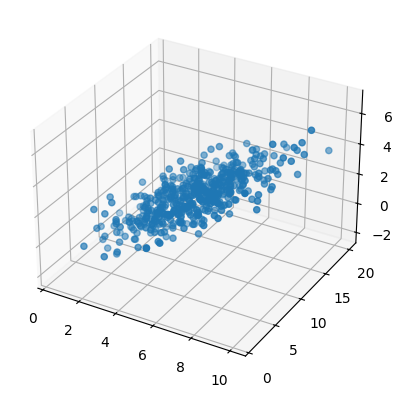

In [2]:
# Ex 1
dataset = np.random.multivariate_normal(
    mean=[5, 10, 2],
    cov=[
        [3, 2, 2],
        [2, 10, 1],
        [2, 1, 2],
    ], size=500)

def plot_3d(X):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(
        X[:, 0],
        X[:, 1],
        X[:, 2]
    )
    plt.show()
plot_3d(dataset)

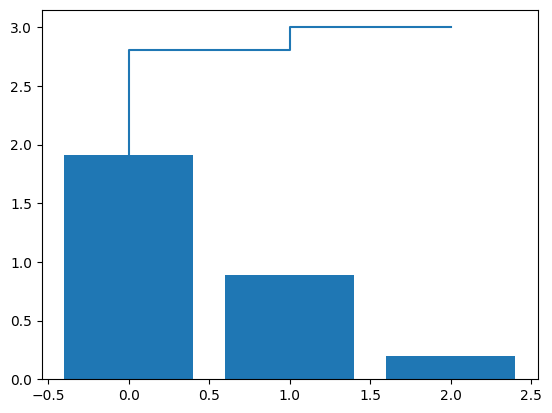

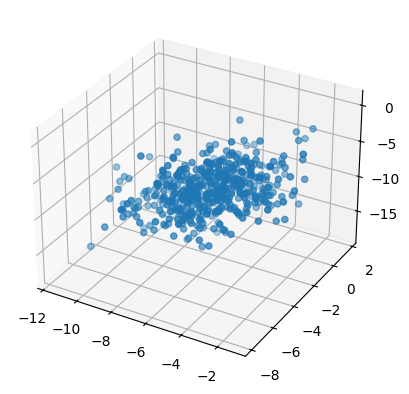

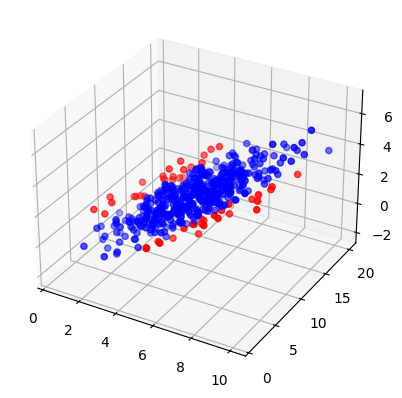

In [3]:
def mean_center(X):
    std_scaler = StandardScaler()
    return std_scaler.fit_transform(X)

def cov_matrix(X):
    return (np.dot(X.T, X)) / X.shape[0]

def print_cumulative_explained_variance(eigenvalues):
    sorted_EVs = np.sort(eigenvalues)
    sorted_EVs = np.flip(sorted_EVs)
    cev = np.cumsum(sorted_EVs)
    plt.step(np.arange(cev.shape[0]), cev)
    plt.bar(np.arange(cev.shape[0]), sorted_EVs)
    plt.show()

def pca(X):
    mcX = mean_center(X)
    covX = cov_matrix(mcX)

    eigenvalues, eigenvectors = np.linalg.eig(covX)

    print_cumulative_explained_variance(eigenvalues)

    sqrtDeltaInverse = np.diag(1/np.sqrt(eigenvalues))

    transformedDataSpace = np.dot(X, eigenvectors)
    normalizedDataSpace = np.dot(transformedDataSpace, sqrtDeltaInverse)
    plot_3d(normalizedDataSpace)

    last_pc = np.argmin(eigenvalues)
    last_pc_vals = normalizedDataSpace[:, last_pc]
    last_pc_vals = np.abs(last_pc_vals - last_pc_vals.mean())
    
    threshold = np.quantile(last_pc_vals, 0.9)
    outliers = last_pc_vals > threshold

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(
        X[outliers != True, 0],
        X[outliers != True, 1],
        X[outliers != True, 2],
        c='blue'
    )
    ax.scatter(
        X[outliers, 0],
        X[outliers, 1],
        X[outliers, 2],
        c='red'
    )
    plt.show()

pca(dataset)

0.07286892758936755


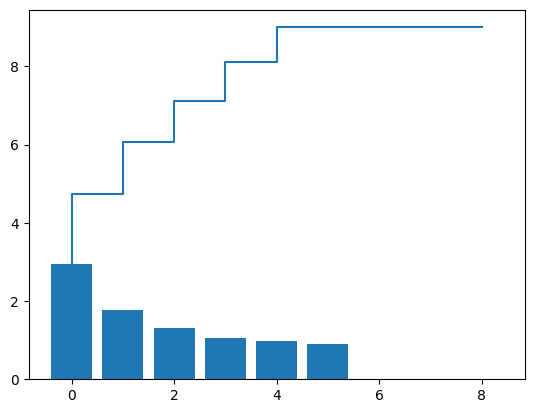

In [4]:
# Ex. 2
mat = loadmat('shuttle')
X_train, X_test, y_train, y_test = train_test_split(mat['X'], mat['y'], train_size=0.4)
contamination_rate = y_train[y_train==True].shape[0] / y_train.shape[0]
print(contamination_rate)

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

pca = PCA()
pca.fit(X_train)
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)
print_cumulative_explained_variance(pca.explained_variance_)

centered_train_pca = train_pca - train_pca.mean(axis=0)
centered_test_pca = test_pca - train_pca.mean(axis=0)
train_scores = np.linalg.norm(centered_train_pca, axis=1)
test_scores = np.linalg.norm(centered_test_pca, axis=1)
threshold = np.quantile(train_scores, 1-contamination_rate)
train_pred = train_scores > threshold
test_pred = test_scores > threshold

In [5]:
y_train_acc = np.reshape(y_train, -1) == 1
y_test_acc = np.reshape(y_test, -1) == 1

train_ba = balanced_accuracy_score(y_train_acc, train_pred)
test_ba = balanced_accuracy_score(y_test_acc, test_pred)

print('train ba: ', train_ba)
print('test ba: ', test_ba)

train ba:  0.9713580339029186
test ba:  0.9755776289800999


In [ ]:
kpca = KPCA(contamination=contamination_rate)
kpca.fit(X_train)

train_pred = kpca.predict(X_train)
test_pred = kpca.predict(X_test)

train_ba = balanced_accuracy_score(y_train_acc, train_pred)
test_ba = balanced_accuracy_score(y_test_acc, test_pred)

print('train ba: ', train_ba)
print('test ba: ', test_ba)